In [8]:
import pandas as pd
pd.options.display.max_rows = 10 #None
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import timedelta
cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']

dict = {}

for cantonId in cantonKeys:
    d = pd.read_csv("data/merged/"+cantonId+".csv")
    d = d.set_index('date')
    dict[cantonId] = d





In [2]:
'''
counter = 0
for col in dict['AG'].columns:
    print(col)
    counter = counter + 1
print(counter)
'''

"\ncounter = 0\nfor col in dict['AG'].columns:\n    print(col)\n    counter = counter + 1\nprint(counter)\n"

In [3]:
yesterday = str(datetime.date.today()- timedelta(days = 1))
df = dict['AG']['2020-02-15':'2021-04-05'] #use '2021-04-05' for testing

for col in df.columns:
    print(col+" (#NaN/total): (" + str(df[col].isna().sum())+"/"+str(df[col].notna().sum())+")")


Cases entries 0 - 9 (#NaN/total): (357/59)
Cases entries 10 - 19 (#NaN/total): (357/59)
Cases entries 20 - 29 (#NaN/total): (357/59)
Cases entries 30 - 39 (#NaN/total): (357/59)
Cases entries 40 - 49 (#NaN/total): (357/59)
Cases entries 50 - 59 (#NaN/total): (357/59)
Cases entries 60 - 69 (#NaN/total): (357/59)
Cases entries 70 - 79 (#NaN/total): (357/59)
Cases entries 80+ (#NaN/total): (357/59)
Cases inz_entries 0 - 9 (#NaN/total): (357/59)
Cases inz_entries 10 - 19 (#NaN/total): (357/59)
Cases inz_entries 20 - 29 (#NaN/total): (357/59)
Cases inz_entries 30 - 39 (#NaN/total): (357/59)
Cases inz_entries 40 - 49 (#NaN/total): (357/59)
Cases inz_entries 50 - 59 (#NaN/total): (357/59)
Cases inz_entries 60 - 69 (#NaN/total): (357/59)
Cases inz_entries 70 - 79 (#NaN/total): (357/59)
Cases inz_entries 80+ (#NaN/total): (357/59)
Cases inzsumTotal 0 - 9 (#NaN/total): (357/59)
Cases inzsumTotal 10 - 19 (#NaN/total): (357/59)
Cases inzsumTotal 20 - 29 (#NaN/total): (357/59)
Cases inzsumTotal 30 

<AxesSubplot:xlabel='date'>

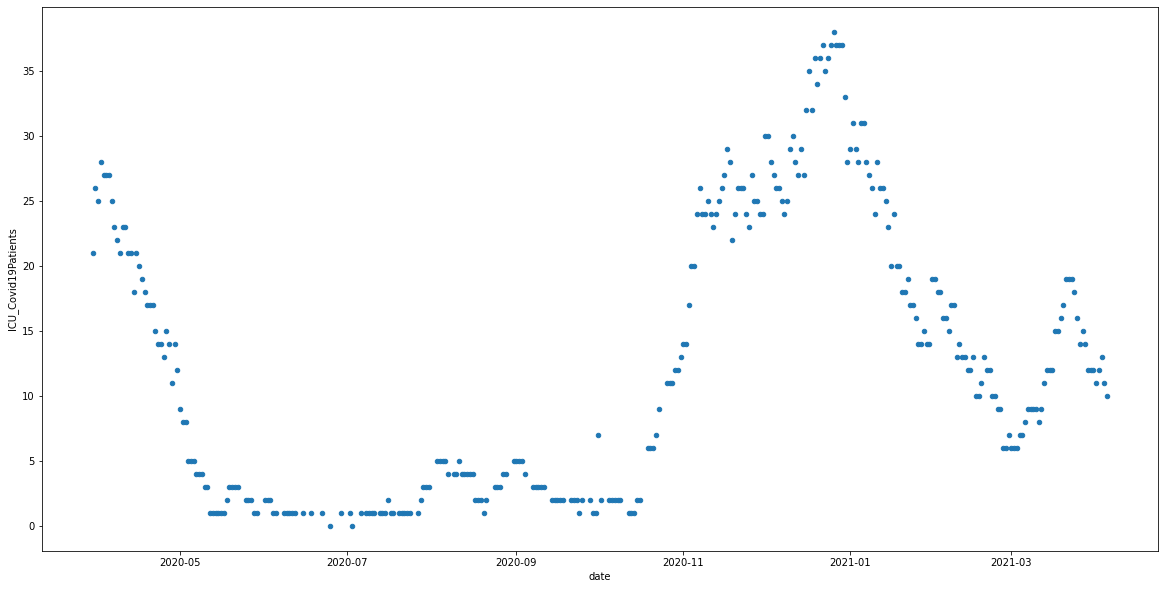

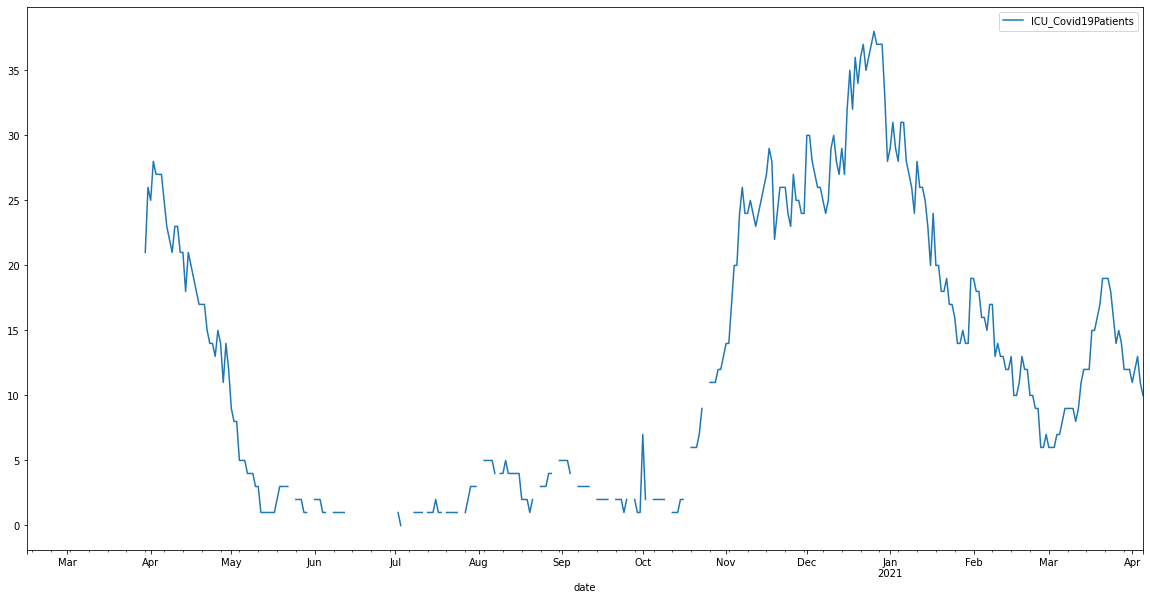

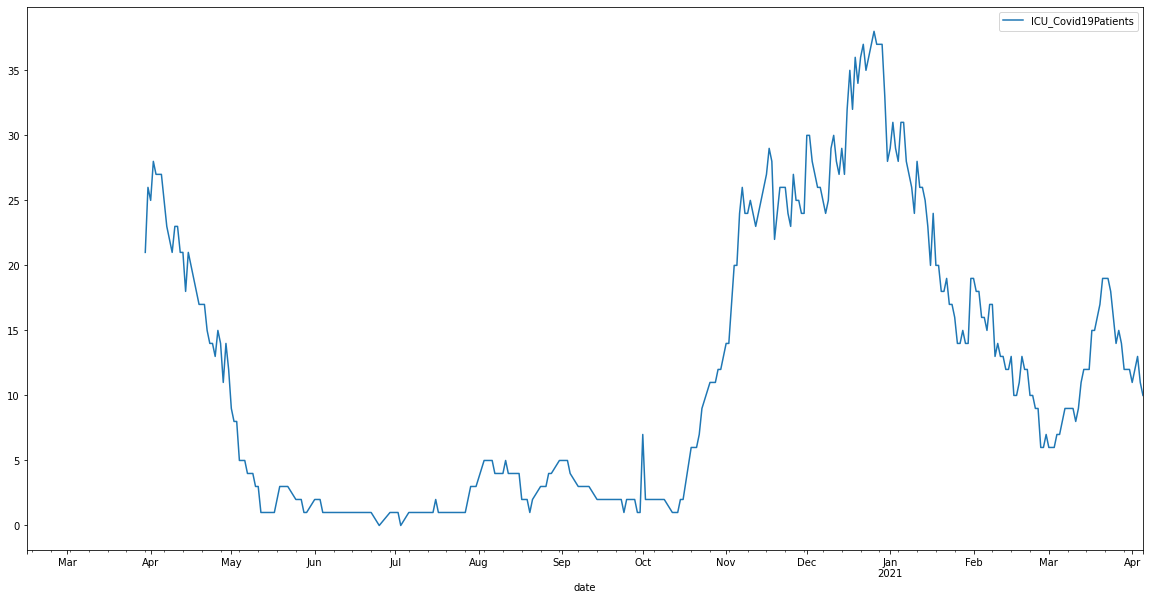

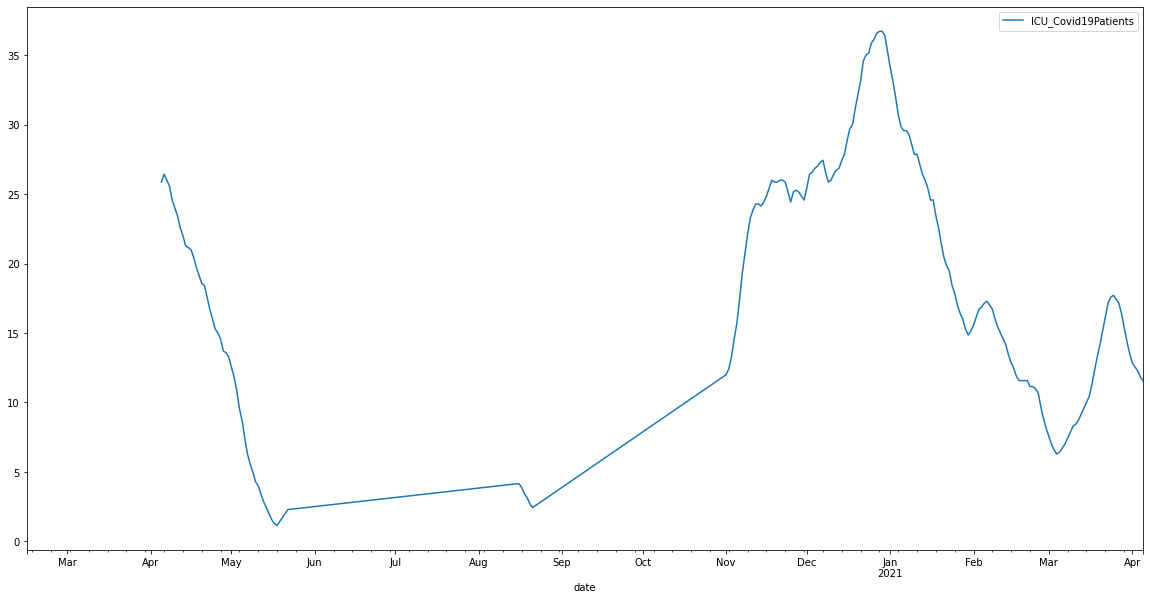

In [4]:
df.index = pd.to_datetime(df.index)
feature = ['ICU_Covid19Patients'] #, 'ICU_FreeCapacity', 'ICU_AllPatients', 'ICU_NonCovid19Patients'
#feature = ['Total_Covid19Patients','Total_NonCovid19Patients','Total_FreeCapacity','Total_AllPatients']

#feature = ['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']
#feature = ['meanNeighborIncidence','maxNeighborIncidence']

#feature = ['median_R_mean','median_R_highHPD','median_R_lowHPD']
#feature = ['lower_ci_day','upper_ci_day','anteil_pos']

#feature = ['case_entries','hosp_entries','death_entries','test_entries'] #
#feature = ['case_inz_entries','hosp_inz_entries','death_inz_entries','test_inz_entries']
#feature = ['test_inzsumTotal'] #'case_inzsumTotal','hosp_inzsumTotal','death_inzsumTotal',




df.reset_index().plot(kind='scatter', x='date', y=feature[0], figsize=(20,10))
df[feature].plot(kind='line', y=feature, figsize=(20,10))
df[feature].interpolate(method='linear').plot(kind='line', y=feature, figsize=(20,10))
df[feature].rolling(window=7).mean().interpolate(method='linear').plot(kind='line', y=feature, figsize=(20,10))


In [5]:
# exploring google mobility data

plotDict = {}
'''
plotDict['googleMob'] = ['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline',
'parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline',
'workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']

plotDict['intervistaMob'] = ['intervistaMob']

plotDict['kof'] = ['kofStrigency']

plotDict['temperature'] = ['temp_min','temp_max']

plotDict['precipitation'] = ['precipitation']

plotDict['clouds'] =['clouds']

plotDict['neigbohr'] = ['meanNeighborIncidence','maxNeighborIncidence']

plotDict['rvalue'] = ['median_R_mean','median_R_highHPD','median_R_lowHPD']

plotDict['variant'] = ['lower_ci_day','upper_ci_day','anteil_pos']

plotDict['entries'] = ['case_entries','hosp_entries','death_entries']
'''
plotDict['cases_agegroup'] = ['Cases entries 0 - 9','Cases entries 10 - 19','Cases entries 20 - 29','Cases entries 30 - 39',
                          'Cases entries 40 - 49','Cases entries 50 - 59','Cases entries 60 - 69','Cases entries 70 - 79',
                          'Cases entries 80+']
'''
plotDict['vaccineSum'] = ['VaccDosesAdministered sumTotal','FullyVaccPersons sumTotal']

plotDict['vaccinePer100Person'] = ['VaccDosesAdministered per100PersonsTotal','FullyVaccPersons per100PersonsTotal']

plotDict['death'] = ['Death entries 0 - 9','Death entries 10 - 19','Death entries 20 - 29','Death entries 30 - 39',
                     'Death entries 40 - 49','Death entries 50 - 59','Death entries 60 - 69','Death entries 70 - 79',
                     'Death entries 80+']

for colsOfInterest in plotDict:
    pltDf = dict['AG']
    pltDf = pltDf[plotDict[colsOfInterest]]
    display(pltDf)
    #df.index = pd.to_datetime(df.index)
    pltDf.plot.scatter(x=df.index,y=colsOfInterest)
    #df[plotDict[colsOfInterest]].rolling(window=7).mean().interpolate(method='linear').plot(kind='line', y=plotDict[colsOfInterest], figsize=(20,10))
    plt.show()
    #.rolling(window=7).mean()
'''

"\nplotDict['vaccineSum'] = ['VaccDosesAdministered sumTotal','FullyVaccPersons sumTotal']\n\nplotDict['vaccinePer100Person'] = ['VaccDosesAdministered per100PersonsTotal','FullyVaccPersons per100PersonsTotal']\n\nplotDict['death'] = ['Death entries 0 - 9','Death entries 10 - 19','Death entries 20 - 29','Death entries 30 - 39',\n                     'Death entries 40 - 49','Death entries 50 - 59','Death entries 60 - 69','Death entries 70 - 79',\n                     'Death entries 80+']\n\nfor colsOfInterest in plotDict:\n    pltDf = dict['AG']\n    pltDf = pltDf[plotDict[colsOfInterest]]\n    display(pltDf)\n    #df.index = pd.to_datetime(df.index)\n    pltDf.plot.scatter(x=df.index,y=colsOfInterest)\n    #df[plotDict[colsOfInterest]].rolling(window=7).mean().interpolate(method='linear').plot(kind='line', y=plotDict[colsOfInterest], figsize=(20,10))\n    plt.show()\n    #.rolling(window=7).mean()\n"

In [6]:
'''
fig, ax = plt.subplots()
ax2 = ax.twinx()
column = "ICUPercent_FreeCapacity"
for cantonId in cantonKeys:
    df = dict[cantonId].rename(columns = {column:cantonId+'_'+column}, inplace = False)
    df.rolling(window=7).mean().plot(y=[cantonId+'_'+column], ax=ax, figsize=(20,10))
plt.show()
'''

'\nfig, ax = plt.subplots()\nax2 = ax.twinx()\ncolumn = "ICUPercent_FreeCapacity"\nfor cantonId in cantonKeys:\n    df = dict[cantonId].rename(columns = {column:cantonId+\'_\'+column}, inplace = False)\n    df.rolling(window=7).mean().plot(y=[cantonId+\'_\'+column], ax=ax, figsize=(20,10))\nplt.show()\n'

In [7]:
from scipy.ndimage.interpolation import shift
copy = dict['AG'].copy()

dict['AG']['case_entries_shifted'] = np.roll(np.array(copy['case_entries']), 14)


corr_matrix = dict['AG'].corr()
display(corr_matrix['case_entries_shifted'].sort_values(ascending=False))

case_entries_shifted         1.000000
meanNeighborIncidence        0.924560
maxNeighborIncidence         0.908300
case_entries                 0.862082
case_inz_entries             0.862079
                               ...   
Death entries 20 - 29             NaN
Death inz_entries 10 - 19         NaN
Death inz_entries 20 - 29         NaN
Death inzsumTotal 10 - 19         NaN
Death inzsumTotal 20 - 29         NaN
Name: case_entries_shifted, Length: 169, dtype: float64

<AxesSubplot:>

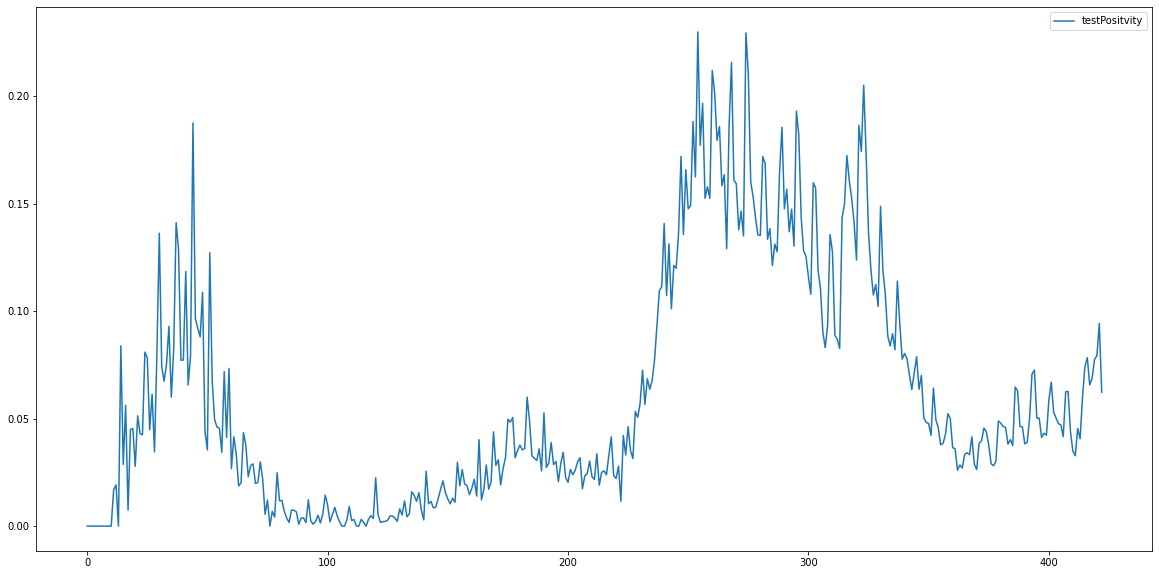

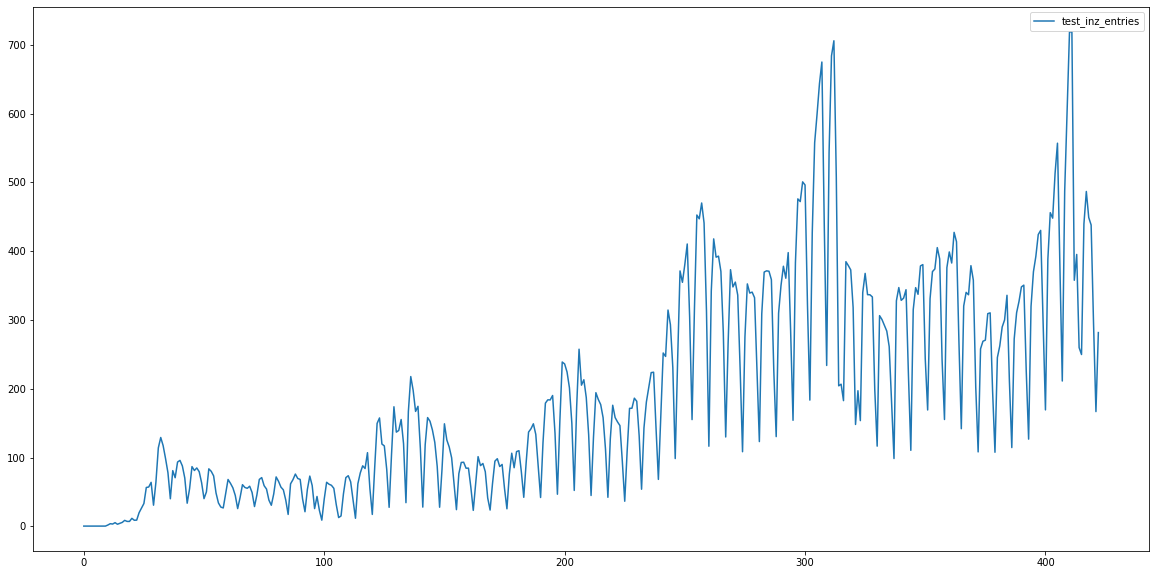

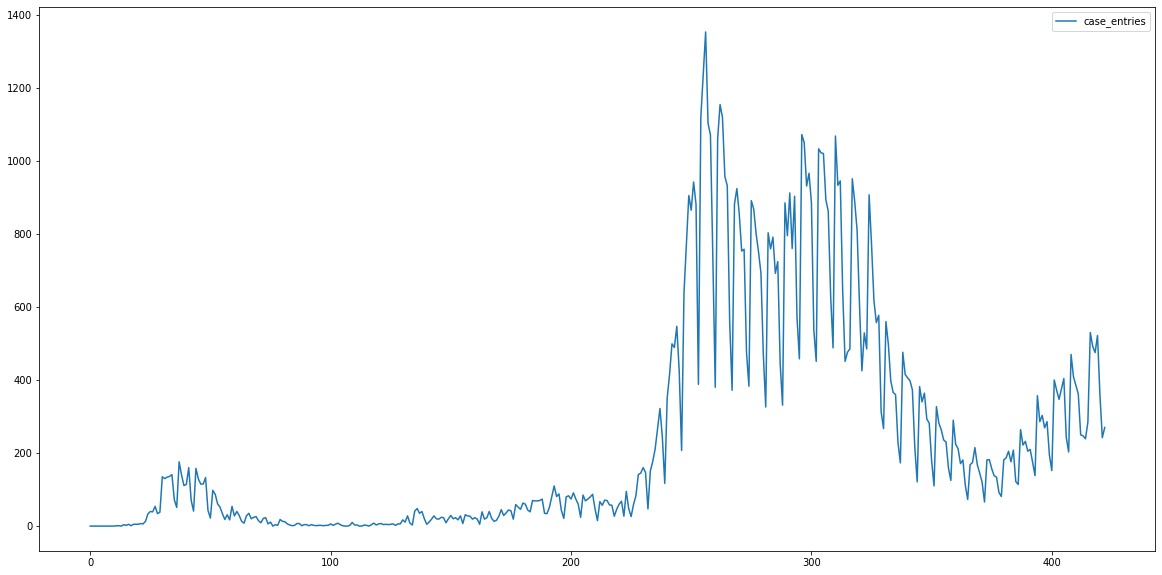

In [13]:
df = pd.read_csv("data/dailyFeatures/ZH.csv")

df[['test_inz_entries','testPositvity']].plot(kind='line', y=['testPositvity'], figsize=(20,10))
df[['test_inz_entries','testPositvity']].plot(kind='line', y=['test_inz_entries'], figsize=(20,10))

df2 = pd.read_csv("data/filled/ZH.csv")

df2[['case_entries']].plot(kind='line', y=['case_entries'], figsize=(20,10))



